## Overview
Objective of this project is to to train a car to mimic driving behavior of human using a deep neural network. I tried to record my driving around track 1 but it was a bit hard to do with the keyboard and trying to capture the recovery data. I decided to use the dataset provided by Udacity instead. The goal of this project is to teach a computer to drive around the track in different lighting and road conditions. In order to do that I had to generate a lot of data on the fly using keras fit_generator and python generator to train the model. To prevent overfitting, I used augmentation techniques to create different images from the same image and and split the data between training and validation sets. After training, the model was able to drive the car on track 1. 


## Exploring the Dataset
The dataset provided by Udacity has about 24108 images recorded from the left, center and right cameras. The images have 160x320x3 dimensions. 

From the histogram image below, most of the images were from driving straight and turning left. Therefore the data is not balanced.

Here are some images from the dataset.

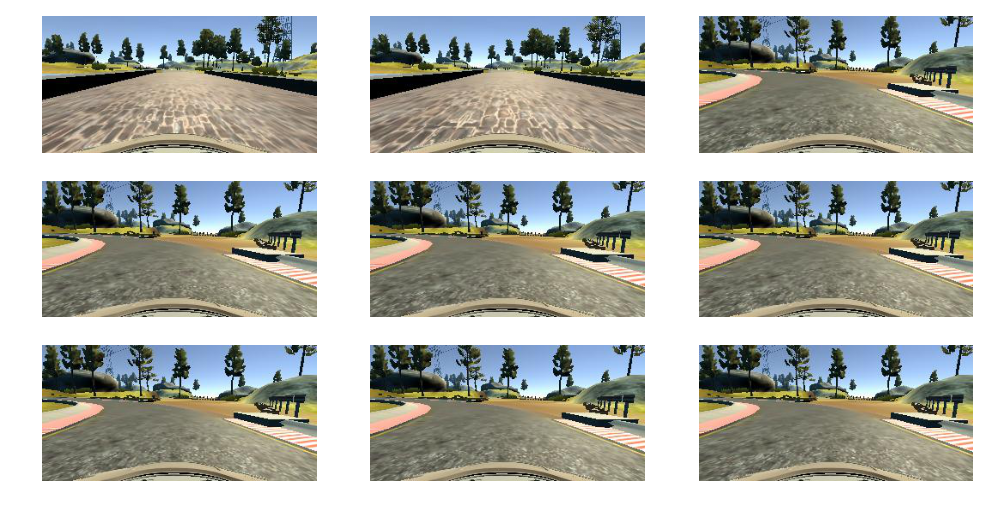

In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

files = glob.glob('data/IMG/*')

S = np.ones((9,160,320,3), dtype=np.uint8)

plt.rcParams['figure.figsize'] = (12, 6)

for i in range(9):
    image = mpimg.imread(files[i])
    S[i] = image
    plt.subplot(3, 3, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e919c18>]], dtype=object)

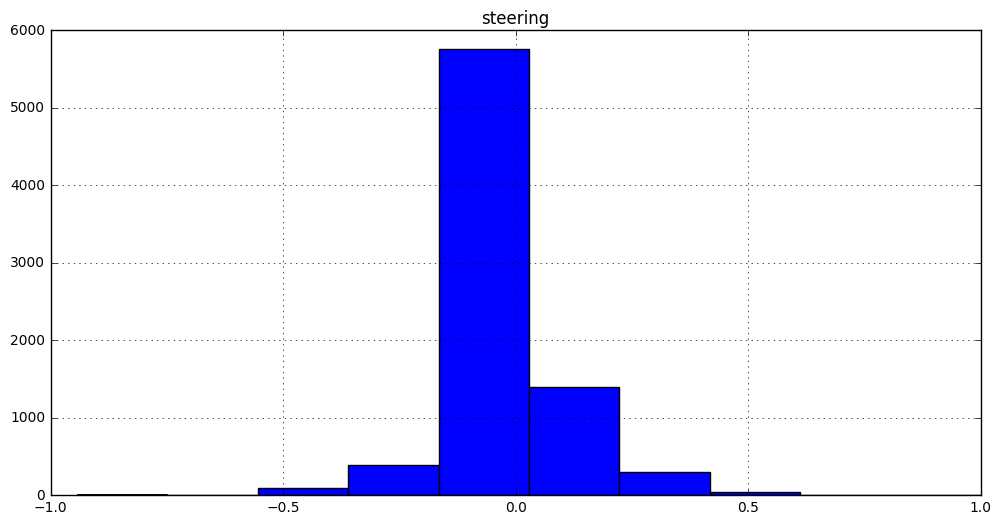

In [3]:
import pandas as pd

df = pd.read_csv('data/driving_log.csv')
df.describe(include='all')
df.hist(column='steering')

## Data Preprocessing  and Augmentation
Images from all 3 cameras (left, center, right) were used. I went through the following steps to augment and preprocess images before feeding them to the neural network for training:

1. Remove data with throttle below .25
2. Resize input image from 160x320 to 64x64
3. Crop the top pixels(1/5) to remove the portion above the horizon and remove 25 pixels from the lower portion of the image to remove the hood of the car since they're just noise.
4. Adjust the steering angle for left (+.25) and right(-.25) cameras to simulate recovery when then car wanders off.
5. Since we have more images of the car right left than right, I flip the image horizontally and reverse the steering angle to simulate turning left/right.
6. Adjust the brightness of the image to simulate driving under different conditions.
7. Normalize all the images. 


For credits, I learned the techniques from the following sources:
- http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
- https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.d779iwp28) 


## Data Generation
I used python data generator to create new images on the fly and they went through the preprocessing steps I listed above before being fed into the model for training. 


## Model Architecture

I used Comma.ai's open source steering model for this project. I removed the first Lambda layer because the logic is already done in my data generator.

- Convolution Layers
    - Conv layer with 16 8x8 filters, followed by ELU activation
    - Conv layer with 32 5x5 filters, followed by ELU activation
    - Conv layer with 64 5x5 filters
- Flatten Layer
    - Flatten layer followed by Dropout(0.2) and ELU activation
- Fully Connected Layers
    - Fully connected layer with 512 output neurons, Dropout(0.5) and ELU activation
    - Fully connected layer with 1 output neuron

For reference: 
https://github.com/commaai/research/blob/master/train_steering_model.py

## Training/Validation
1. Optimizer: I used Adam with Nesterov momentum (http://cs229.stanford.edu/proj2015/054_report.pdf)
2. No. of epochs: 8
3. Batch size = 32
3. Training and validation sets were generated on the fly using python generator and keras fit_generator to feed in the data to the model for training. 
4. There's no testing set because I can evaluate the model by loading the model weight file in the simulator and see how well the car performs around track 1 for several laps.
5. I noticed if I increased more epochs, the performance got worst instead of better. 

## Simulation
I've made the following changes to drive.py file:
- Called preprocessing for input images
- Changed throttle to 0.2. If I changed it to 0.1, the drive was much smoother and it generalized well on track 2 as well.
